Code for peak shaving optimization

In [19]:
#import packages
import numpy as np
import pandas as pd
import cvxpy as cp
import gurobipy
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import HTML
HTML('''<style>.CodeMirror{min-width:100% !important;}</style>''')

# Data pre-processing

In [2]:
#Add date parser to read in the date as an actual date object
date_parser = lambda x: datetime.strptime(x, '%d-%b-%Y')
demand = pd.read_csv('./data/ColumbiaDemand.csv', parse_dates=['Date'], date_parser=date_parser) 
demand.head()
#Restructure into one list of demands for each month

,Date,TotalDemand [kWh],Period01 [kWh],Period02 [kWh],Period03 [kWh],Period04 [kWh],Period05 [kWh],Period06 [kWh],Period07 [kWh],Period08 [kWh],...,Period87 [kWh],Period88 [kWh],Period89 [kWh],Period90 [kWh],Period91 [kWh],Period92 [kWh],Period93 [kWh],Period94 [kWh],Period95 [kWh],Period96 [kWh]
0,2018-01-01,72686.88,734.40,731.52,727.20,735.84,730.08,728.64,731.52,730.08,...,740.16,741.60,734.40,735.84,735.84,730.08,725.76,731.52,728.64,724.32
1,2018-01-02,73594.08,728.64,727.20,728.64,727.20,732.96,734.40,734.40,737.28,...,743.04,741.60,741.60,738.72,750.24,743.04,750.24,738.72,738.72,743.04
2,2018-01-03,73440.00,745.92,743.04,745.92,744.48,741.60,734.40,735.84,734.40,...,734.40,732.96,721.44,714.24,721.44,725.76,727.20,724.32,731.52,722.88
3,2018-01-04,73967.04,718.56,718.56,724.32,727.20,720.00,724.32,725.76,720.00,...,747.36,744.48,735.84,734.40,741.60,743.04,738.72,741.60,740.16,735.84
4,2018-01-05,74625.12,745.92,743.04,744.48,741.60,737.28,743.04,747.36,748.80,...,767.52,768.96,760.32,758.88,756.00,756.00,753.12,754.56,750.24,745.92


In [3]:
#Drop total demand columns and pivot
demand_unpivoted = demand[demand.columns.difference(['TotalDemand [kWh]'])].melt(id_vars=['Date'], var_name='period', value_name='demand')
#Make sure to sore by date and period
demand_unpivoted = demand_unpivoted.sort_values(by=['Date','period']).reset_index(drop=True)
demand_unpivoted['year'] = demand_unpivoted['Date'].apply(lambda x: x.year)
demand_unpivoted['month'] = demand_unpivoted['Date'].apply(lambda x: x.month)
demand_unpivoted = demand_unpivoted.fillna(0)
demand_unpivoted.head() 

,Date,period,demand,year,month
0,2018-01-01,Period01 [kWh],734.40,2018,1
1,2018-01-01,Period02 [kWh],731.52,2018,1
2,2018-01-01,Period03 [kWh],727.20,2018,1
3,2018-01-01,Period04 [kWh],735.84,2018,1
4,2018-01-01,Period05 [kWh],730.08,2018,1


## Example of data selection for a single month (and year)

In [4]:
jan_2018 = demand_unpivoted[(demand_unpivoted['year']==2018) & (demand_unpivoted['month'] == 1)]
# Add column for rolling sum of current row and preious for demand\n",
jan_2018['rolling_demand'] = jan_2018[['demand']].rolling(2).sum()
jan_2018.head()

/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_68602/2184305333.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_2018['rolling_demand'] = jan_2018[['demand']].rolling(2).sum()


,Date,period,demand,year,month,rolling_demand
0,2018-01-01,Period01 [kWh],734.40,2018,1,NaN
1,2018-01-01,Period02 [kWh],731.52,2018,1,1465.92
2,2018-01-01,Period03 [kWh],727.20,2018,1,1458.72
3,2018-01-01,Period04 [kWh],735.84,2018,1,1463.04
4,2018-01-01,Period05 [kWh],730.08,2018,1,1465.92


In [5]:
jan_2018_demand = np.array(jan_2018['demand'])
jan_2018_demand

array([734.4 , 731.52, 727.2 , ..., 705.6 , 708.48, 711.36])

### Find the peak period for a month
Assumptions: 
* 15-minute intervals are continuous throughout the month, so one day continues into the next day
* If one of the 2 periods of peak demand occur during the high/low tension service then the higher price is assumed for the peak demand charge
    * i.e. peak periods occur at 7:45am and 8am, assume the peak demand charge is $13.96+$4.21

In [6]:
#Print location where the demand is a maximum - get the period and see the charges
print('rolling max demand is ', jan_2018['rolling_demand'].max(), 'at index ',jan_2018['rolling_demand'].argmax())
print('The max periods are: ', jan_2018.loc[jan_2018['rolling_demand'].argmax()-1]['period'], ' and ', jan_2018.loc[jan_2018['rolling_demand'].argmax()]['period'])
print('Peak periods at hours: ', str(int(jan_2018.loc[jan_2018['rolling_demand'].argmax()-1]['period'].split('Period')[1].split(' ')[0])/4), ' and ', str(int(jan_2018.loc[jan_2018['rolling_demand'].argmax()]['period'].split('Period')[1].split(' ')[0])/4))
print('Look at the data at that period: ')
jan_2018[jan_2018['rolling_demand'].argmax()-2:jan_2018['rolling_demand'].argmax()+2]

rolling max demand is  1905.12 at index  720
The max periods are:  Period48 [kWh]  and  Period49 [kWh]
Peak periods at hours:  12.0  and  12.25
Look at the data at that period: 


,Date,period,demand,year,month,rolling_demand
718,2018-01-08,Period47 [kWh],947.52,2018,1,1889.28
719,2018-01-08,Period48 [kWh],953.28,2018,1,1900.80
720,2018-01-08,Period49 [kWh],951.84,2018,1,1905.12
721,2018-01-08,Period50 [kWh],953.28,2018,1,1905.12


## Analysis of peak demand period

In [7]:
peak_analysis = pd.DataFrame(columns=['month','year','peak_demand','periods', 'hours','peak_cost'])
summer_charge_tiers = [16.66, 18.44, 9.15]
other_charge_tiers = [4.21, 13.96]
for year in [2018, 2019]:
    for month in range(1,13):
        print(f'{month}/{year}')
        df = demand_unpivoted[(demand_unpivoted['year']==year) & (demand_unpivoted['month'] == month)].reset_index(drop=True)
        # Add column for rolling sum of current row and preious for demand\n",
        df['rolling_demand'] = df[['demand']].rolling(2).sum()
        #Print location where the demand is a maximum - get the period and see the charges
        #Add row to dataframe of resulsts
        peak_demand = df['rolling_demand'].max()
        period1 = df.loc[df['rolling_demand'].argmax()-1]['period']
        period2 = df.loc[df['rolling_demand'].argmax()]['period']
        hour1 = int(df.loc[df['rolling_demand'].argmax()-1]['period'].split('Period')[1].split(' ')[0])/4
        hour2 = int(df.loc[df['rolling_demand'].argmax()]['period'].split('Period')[1].split(' ')[0])/4
        #If the hour is in a peak period, then mark as such
        #Between 8am-10pm
        if (hour1 >= 8) and (hour1 <=22):
            # Charge for June, July, August, September
            if month in [6, 7, 8, 9]:
                #Between 8am-6pm
                if hour1 <= 18:
                    peak_charge = summer_charge_tiers[0] + summer_charge_tiers[1] + summer_charge_tiers[2]
                else:
                    peak_charge = summer_charge_tiers[0] + summer_charge_tiers[1]
            else:
                peak_charge = other_charge_tiers[0] + other_charge_tiers[1]
        else:
            # Charge for June, July, August, September
            if month in [6, 7, 8, 9]:
                peak_charge = summer_charge_tiers[0]
            else:
                peak_charge = other_charge_tiers[0]

        peak_analysis.loc[len(peak_analysis.index)] =[month, year, peak_demand,[period1,period2], [hour1, hour2], peak_charge]
        print('rolling max demand is ', peak_demand, 'at index ',df['rolling_demand'].argmax())
        print('The max periods are: ', period1, ' and ', period2)
        print('Peak periods at hours: ', str(hour1), ' and ', str(hour2))

1/2018
rolling max demand is  1905.12 at index  720
The max periods are:  Period48 [kWh]  and  Period49 [kWh]
Peak periods at hours:  12.0  and  12.25
2/2018
rolling max demand is  1716.48 at index  1222
The max periods are:  Period70 [kWh]  and  Period71 [kWh]
Peak periods at hours:  17.5  and  17.75
3/2018
rolling max demand is  1748.1599999999999 at index  2846
The max periods are:  Period62 [kWh]  and  Period63 [kWh]
Peak periods at hours:  15.5  and  15.75
4/2018
rolling max demand is  1716.48 at index  2352
The max periods are:  Period48 [kWh]  and  Period49 [kWh]
Peak periods at hours:  12.0  and  12.25
5/2018
rolling max demand is  2056.32 at index  1409
The max periods are:  Period65 [kWh]  and  Period66 [kWh]
Peak periods at hours:  16.25  and  16.5
6/2018
rolling max demand is  2224.8 at index  1686
The max periods are:  Period54 [kWh]  and  Period55 [kWh]
Peak periods at hours:  13.5  and  13.75
7/2018
rolling max demand is  2367.3599999999997 at index  249
The max periods 

In [8]:
print('Summer peak cost: ', peak_analysis[peak_analysis['month'].isin([6,7,8,9])]['peak_cost'].unique())
print('Other Month peak cost: ', peak_analysis[-peak_analysis['month'].isin([6,7,8,9])]['peak_cost'].unique())

Summer peak cost:  [44.25]
Other Month peak cost:  [18.17]


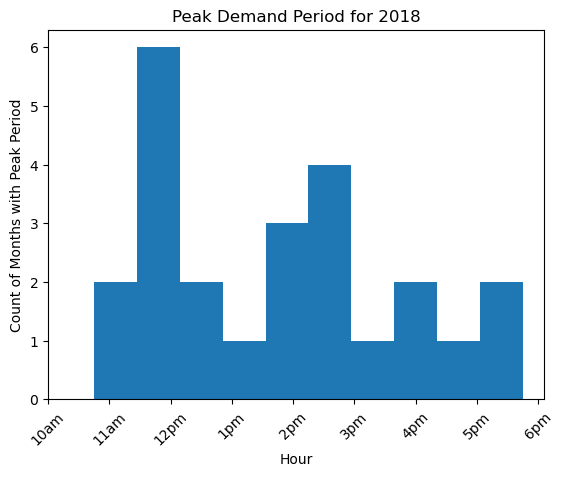

In [9]:
hours = np.array(peak_analysis[peak_analysis['year'] == 2018]['hours']).flatten()
hours = [item for sublist in hours for item in sublist]
_ = plt.hist(hours)
_ = plt.xticks(ticks=[10, 11, 12, 13, 14, 15, 16, 17, 18], labels=['10am','11am','12pm','1pm','2pm','3pm','4pm','5pm','6pm'], rotation=45)
_ = plt.title('Peak Demand Period for 2018')
_ = plt.xlabel('Hour')
_ = plt.ylabel('Count of Months with Peak Period')

From the above analysis, we see that over all months, the peak demand occurs during the most expensive time period. We can assume this will be the case throughout our analysis and set B = most expensive peak demand charge option for that month.

# Optimization

In [10]:
jan_2018_demand

array([734.4 , 731.52, 727.2 , ..., 705.6 , 708.48, 711.36])

In [11]:
def run_optimization(D, P, battery, month, e_0):
    """
    Description: Code to run the optimization procedure

    Inputs:
        D, np.array: demand for each period
        P, float: battery power rating
        battery, str : battery option either "li-ion" or "thermal"
        month, int: month of year
        e_0, float: energy stored in the battery and the start of the month
    
    Output:
        Results of optimization
    """
    #Update variables depending on battery type
    if battery == 'li-ion':
        #battery efficiency
        eta = .95
        #Energy rating
        E = 4*P
        #Define additional variables
        cost_P = 300*P
        cost_E = 200*E

    elif battery == 'thermal':
        #battery efficiency
        eta = .7
        #Energy rating
        E = 12*P
        #Define additional variables
        cost_P = 500*P
        cost_E = 50*E

    else:
        print('optimizing without battery...')
        P=0
        eta = .95
        E = 0
        cost_P = 0
        cost_E = 0
    
    #Update peak charges depending on time of year:
    if month in [6, 7, 8, 9]:
        B = 9.15 + 18.44 + 16.66
    else:
        B = 4.21 + 13.96
        
    #Cost of electricity
    C = .13
    
    # Decision Variables
    #Storage discharge power
    d = cp.Variable(len(D), nonneg=True)
    # Storage charge power
    q = cp.Variable(len(D), nonneg=True)
    # Energy storged
    e = cp.Variable(len(D), nonneg=True)
    # peak demand
    p = cp.Variable(nonneg=True)

    # Initialize an empty constraint set
    con_set_1 = []  

    for t in range(len(D)):
        #Can't discharge more than the power rating of battery
        con_set_1.append(d[t] <= P)
        #Can't charge more than the power rating of battery
        con_set_1.append(q[t] <= P)
        # #Can't store more energy than capacity
        con_set_1.append(e[t] <= E)
        if t == 0:
            # state-of charge constraint 1 - assume battery is empty
            # before month starts
            con_set_1.append(e[t] - e_0 == q[t]*eta - d[t]/eta)
        elif t == len(D)-1:
            # # peak demand identification
            con_set_1.append(p >= D[t] - d[t] + q[t])
        else:
            # # state-of charge constraint 1
            con_set_1.append(e[t] - e[t-1] == q[t]*eta - d[t]/eta)
            # # peak demand identification
            con_set_1.append(p >= D[t] - d[t] + q[t] + D[t+1] - d[t+1] + q[t+1])

    #Define Objective - BP + sum over t
    #mutlipy by 2 because p is only a half hour increment right now
    obj = cp.Minimize(2*B*p + C*sum(D - d + q))

    # Solve the problem
    prob1 = cp.Problem(obj, con_set_1)
    prob1.solve(solver = "GUROBI", reoptimize=True)
    prob1.solve();

    # print(f'\tCost from electricity: ${prob1.value:,.0f}')
    # print(f'\tCost from battery: ${(cost_E+cost_P):,.0f}')
    # print(f'\tTotal Cost: ${(cost_E+cost_P + prob1.value):,.0f}')
    # print(f'\tPeak demand: {p.value:.2f}')
    return(prob1.value, cost_E, cost_P, e)

In [13]:
#Run optimization for 2/2018 using code below
monthly_cost, cost_E, cost_P, e = run_optimization(D = np.array(demand_unpivoted[(demand_unpivoted['year']==2018) & (demand_unpivoted['month'] == 2)]['demand']),P = 50, battery = 'thermal', month = 2, e_0=0)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-20


In [14]:
#Find the capacity of the battery in the last period - will lead into the next month
e.value[-1]

300.9975782576277

In [15]:
monthly_results = pd.DataFrame(columns=['month', 'monthly_cost', 'cost_E', 'cost_P', 'P', 'battery_type', 'end_e'])
for battery in ['No','thermal','li-ion']:
    if battery == 'thermal':
        powers = np.arange(50,800,50)
    elif battery == 'li-ion':
        powers = np.arange(50,800,50)
    else:
        powers = [0]
    for power in powers:
        for month in range(1,13):
            demand_array = np.array(demand_unpivoted[(demand_unpivoted['year']==2018) & (demand_unpivoted['month'] == month)]['demand'])
            print(f'Optimizing {month}/2018 with {power} kW {battery} battery...')
            if month == 1:
                monthly_cost, cost_E, cost_P, e = run_optimization(D = demand_array, P = power, battery = battery, month = month, e_0=0)
                #update the energy stored in the battery based on the final period
                e_0 = e.value[-1]
            else:
                monthly_cost, cost_E, cost_P, e_0 = run_optimization(D = demand_array, P = power, battery = battery, month = month, e_0=e_0)
                #update the energy stored in the battery based on the final period
                e_0 = e.value[-1]
            monthly_results.loc[len(monthly_results.index)] =[month, monthly_cost, cost_E,cost_P, power, battery, e_0]

Optimizing 1/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 2/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 3/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 4/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 5/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 6/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 7/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 8/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 9/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 10/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 11/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 12/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 1/2018 with 50 kW thermal battery...
Optimizing 2/2018 with 50 kW thermal battery...
Optimizing 3/2018 with 50 kW thermal 

In [18]:
cost_0 = round(np.sum(monthly_results[monthly_results['P'] == 0]['monthly_cost']),0)
for battery in ['thermal','li-ion']:
    print(f'{battery} results:')
    battery_results = monthly_results[monthly_results['battery_type'] == battery]
    for P in battery_results['P'].unique():
        cost = round(np.sum(battery_results[battery_results['P'] == P]['monthly_cost']),0)
        cost_diff =  cost_0 - cost
        long_term_cost_diff = cost_diff*10
        battery_cost = round(battery_results[battery_results['P'] == P]['cost_E'].unique().item()+battery_results[battery_results['P'] == P]['cost_P'].unique().item(),0)
        print(f'\t{P}kW {battery} battery: ${cost:,} operating and ${battery_cost:,} for battery - 10-year amount saved: ${long_term_cost_diff-battery_cost:,}' )

thermal results:
	50kW thermal battery: $4,953,534.0 operating and $55,000 for battery - 10-year amount saved: $421,500.0
	100kW thermal battery: $4,932,035.0 operating and $110,000 for battery - 10-year amount saved: $581,490.0
	150kW thermal battery: $4,916,817.0 operating and $165,000 for battery - 10-year amount saved: $678,670.0
	200kW thermal battery: $4,905,181.0 operating and $220,000 for battery - 10-year amount saved: $740,030.0
	250kW thermal battery: $4,895,708.0 operating and $275,000 for battery - 10-year amount saved: $779,760.0
	300kW thermal battery: $4,888,869.0 operating and $330,000 for battery - 10-year amount saved: $793,150.0
	350kW thermal battery: $4,883,364.0 operating and $385,000 for battery - 10-year amount saved: $793,200.0
	400kW thermal battery: $4,878,262.0 operating and $440,000 for battery - 10-year amount saved: $789,220.0
	450kW thermal battery: $4,874,257.0 operating and $495,000 for battery - 10-year amount saved: $774,270.0
	500kW thermal battery

## Optimization outside of a function - for understanding

In [40]:
#Define variables
# Battery Efficiency
# eta = np.array([.95, .7]) #.95 or .7
eta = .95
# Power Rating - assume 100kW battery
P = 0
cost_P = 300*P
# P = np.array([300, 500]) # 300 or 500
# Energy Rating - assume 400kwH battery
E = 4*P
cost_E = 200*E
# E = np.array([200, 50]) # 200 or 50
#Choose a 100kW/200kwH battery
#Battery duration E*P -> if P=1, then E=4 or E=12, if P=2, then E=8 or E=24
# bat_dur = np.array([4, 12])

# Demand
D = jan_2018_demand
# D = january_list, feb_list, ...
# Peak Demand Charge
# On peak month: June, July, August, September
#       8am-6pm, 8am-10pm, all-day
# Off peak month: other
#       8am-10pm, all-day
#Note: periods 32-72 are 8am-6pm, periods 32-88 are 8am-10pm
# B = np.array([[9.15, 18.44, 16.66],
#             [13.96, 4.21]])
C = .13
# B = np.array([13.96, 4.21])
# B = np.array([4.21,])
# daily_cost = np.append(np.append(np.tile(4.21,4*8),np.tile(4.21+13.96,4*14)),np.tile(4.21,4*2))
# B = np.tile(daily_cost, 31)
B = 4.21+13.96
# C_peak = 18.17 # 4.21 + 13.96
# B is some selection of C and its summation

# Decision Variables
#Storage discharge power
d = cp.Variable(len(D), nonneg=True)
# Storage charge power
q = cp.Variable(len(D), nonneg=True)
# Energy storged
e = cp.Variable(len(D), nonneg=True)
# peak demand
p = cp.Variable(nonneg=True)

#Decision variable whether the extra cost is incurred or not
# x = cp.Variable(len(D), boolean = True) 



In [41]:
# Initialize an empty constraint set
con_set_1 = []  

for t in range(len(D)):
    #Can't discharge more than the power rating of battery
    con_set_1.append(d[t] <= P)
    #Can't charge more than the power rating of battery
    con_set_1.append(q[t] <= P)
    # #Can't store more energy than capacity
    con_set_1.append(e[t] <= E)
    if t == 0:
        # state-of charge constraint 1 - assume battery is empty before month starts
        con_set_1.append(e[t] == q[t]*eta - d[t]/eta)
    elif t == len(D)-1:
        # # peak demand identification
        con_set_1.append(p >= D[t] - d[t] + q[t])
    else:
        # # state-of charge constraint 1
        con_set_1.append(e[t] - e[t-1] == q[t]*eta - d[t]/eta)
        # # peak demand identification
        con_set_1.append(p >= D[t] - d[t] + q[t] + D[t+1] - d[t+1] + q[t+1])
        # pmax == p, what is t -> B
        # con_set_1.append(p <= x[t]*10000000)
# con_set_1.append(sum(x) == 1)

In [42]:
#Define Objective - BP + sum over t
#mutlipy by 2 because p is only a half hour increment right now
obj = cp.Minimize(2*B*p + C*sum(D - d + q))

In [43]:
# Solve the problem
prob1 = cp.Problem(obj, con_set_1)
prob1.solve(solver = "GUROBI", reoptimize=True)
prob1.solve();

In [64]:
print(f'Cost without a battery: ${prob1.value:,.0f}')
print(f'peak deamnd: ${p.value:.2f}')

Cost without a battery: $358,325
peak deamnd: $1905.12
